# CDR Model - Ablation Study_1
* 본 모델에서 생성한 Doc2Vec User/Item Embedding 크기를 변경해가며 모델 성능 체크
* User/Item Embedding Size : 16/32/64/128/256
* 실험 결과, Cafe 데이터셋에서는 64로, Bar&Pub 데이터셋에서는 32로 임베딩 크기를 설정하는 것이 최고 성능을 보임

In [ ]:
import pandas as pd
import numpy as np
import os, random, re
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from gensim.models.doc2vec import Doc2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Embedding, Input, Flatten, Multiply, Dense, Activation, Concatenate, Dropout, BatchNormalization, Conv1D, GlobalAveragePooling1D, MaxPooling1D
pd.options.display.max_colwidth=20
pd.options.display.max_columns=999

In [ ]:
rest = pd.read_csv('/content/drive/MyDrive/seminar/cdr_v2/yelp_rest_prepro.csv')
cafe = pd.read_csv('/content/drive/MyDrive/seminar/cdr_v2/yelp_cafe_prepro.csv')
bar = pd.read_csv('/content/drive/MyDrive/seminar/cdr_v2/yelp_bar_prepro.csv')

rest_doc_model_16 = Doc2Vec.load('/content/drive/MyDrive/seminar/cdr_v2/rest_doc_model_16')
cafe_doc_model_16 = Doc2Vec.load('/content/drive/MyDrive/seminar/cdr_v2/cafe_doc_model_16')
bar_doc_model_16 = Doc2Vec.load('/content/drive/MyDrive/seminar/cdr_v2/bar_doc_model_16')

rest_doc_model_64 = Doc2Vec.load('/content/drive/MyDrive/seminar/cdr_v2/rest_doc_model_64')
cafe_doc_model_64 = Doc2Vec.load('/content/drive/MyDrive/seminar/cdr_v2/cafe_doc_model_64')
bar_doc_model_64 = Doc2Vec.load('/content/drive/MyDrive/seminar/cdr_v2/bar_doc_model_64')

rest_doc_model_128 = Doc2Vec.load('/content/drive/MyDrive/seminar/cdr_v2/rest_doc_model_128')
cafe_doc_model_128 = Doc2Vec.load('/content/drive/MyDrive/seminar/cdr_v2/cafe_doc_model_128')
bar_doc_model_128 = Doc2Vec.load('/content/drive/MyDrive/seminar/cdr_v2/bar_doc_model_128')

rest_doc_model_256 = Doc2Vec.load('/content/drive/MyDrive/seminar/cdr_v2/rest_doc_model_256')
cafe_doc_model_256 = Doc2Vec.load('/content/drive/MyDrive/seminar/cdr_v2/cafe_doc_model_256')
bar_doc_model_256 = Doc2Vec.load('/content/drive/MyDrive/seminar/cdr_v2/bar_doc_model_256')

print(rest.shape)
print(cafe.shape)
print(bar.shape)

(1070842, 24)
(28117, 26)
(17735, 42)


In [ ]:
def seed_everything(seed: int=42):
  random.seed(seed)
  np.random.seed(seed)
  os.environ['PYTHONASHSEED'] = str(seed)
  tf.random.set_seed(seed)

seed_everything(42)

In [ ]:
def friends(x):
  '''
  num_friends - 친구의 수로 표현
  '''
  friends = len(x.split(','))

  return friends


def add_side_info(df=None, domain='None'):
  '''
  Rating + Review + User Profile + Context
  business_id, user_id는 knowledge transfer를 위해 지금 수정X
  '''
  if domain == 'bar':
    cols = ['business_id', 'user_id', 'stars_y', 'categories', 'Alcohol', 'BestNights',
            'BestNights_Mon', 'BestNights_Tue', 'BestNights_Fri', 'BestNights_Wed',
            'BestNights_Thu','BestNights_Sun','BestNights_Sat', 'Music', 'video', 'dj',
            'background_music', 'jukebox', 'no_music', 'live', 'karaoke', 'text', 'num_friends', 'fans', 'user_votes']
    new_df = df[cols]

    for col in ['num_friends', 'fans', 'user_votes', 'categories', 'Alcohol', 'BestNights', 'Music']:  # business_id, user_id
      new_df[col] = new_df[col].astype('category')
      new_df[col] = new_df[col].cat.codes.values

  elif domain == 'cafe':
    cols = ['business_id', 'user_id', 'stars_y', 'categories', 'OutdoorSeating', 'DriveThru',
            'text', 'num_friends', 'fans', 'user_votes']
    new_df = df[cols]

    for col in ['num_friends', 'fans', 'user_votes', 'categories', 'OutdoorSeating', 'DriveThru']:   # business_id, user_id
      new_df[col] = new_df[col].astype('category')
      new_df[col] = new_df[col].cat.codes.values

  return new_df

def normalize(x):
  '''
  MLP / GMF / NCF - sigmoid 용 정규화 모델
  Min-Max Scaler 사용
  '''
  normalized_x = (((x-1) / (5-1)))
  return normalized_x

def de_normalize(x):
  '''
  normalize된 평점이 다시 원래 값을 갖도록 설정
  '''
  original_x = 4 * ((x - 0) / (1 - 0)) + 1
  return original_x

def rmse(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

rest['num_friends'] = rest['friends'].apply(lambda x: friends(x))
bar['num_friends'] = bar['friends'].apply(lambda x: friends(x))
cafe['num_friends'] = cafe['friends'].apply(lambda x: friends(x))

rest = rest[['business_id', 'user_id', 'stars_y', 'text', 'num_friends', 'fans', 'user_votes']]
bar = add_side_info(bar, 'bar')
cafe = add_side_info(cafe, 'cafe')

rest['stars_y_scaled'] = rest['stars_y'].apply(lambda x: normalize(x))
bar['stars_y_scaled'] = bar['stars_y'].apply(lambda x: normalize(x))
cafe['stars_y_scaled'] = cafe['stars_y'].apply(lambda x: normalize(x))

<ipython-input-135-f27b873e222d>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[col] = new_df[col].astype('category')
<ipython-input-135-f27b873e222d>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[col] = new_df[col].cat.codes.values
<ipython-input-135-f27b873e222d>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [ ]:
def get_embeddings(model, df=None):
  '''
  학습한 Doc2Vec 모델의 임베딩 부여
  '''
  user_embeddings = []
  for user_id in df['user_id'].unique():
    user_embedding = model.docvecs[user_id]
    user_embeddings.append(user_embedding)
  user_embeddings_dict = dict(zip(df['user_id'].unique(), user_embeddings))
  df['user_embeddings'] = df['user_id'].apply(lambda x: user_embeddings_dict[x])

  bus_embeddings = []

  for bus_id in df['business_id'].unique():
    bus_embedding = model.docvecs[bus_id]
    bus_embeddings.append(bus_embedding)
  bus_embeddings_dict = dict(zip(df['business_id'].unique(), bus_embeddings))
  df['business_embeddings'] = df['business_id'].apply(lambda x: bus_embeddings_dict[x])

  return df

# rest_doc_16 = get_embeddings(rest_doc_model_16, rest)
# cafe_doc_16 = get_embeddings(cafe_doc_model_16, cafe)
# bar_doc_16 = get_embeddings(bar_doc_model_16, bar)

# rest_doc_64 = get_embeddings(rest_doc_model_64, rest)
# cafe_doc_64 = get_embeddings(cafe_doc_model_64, cafe)
# bar_doc_64 = get_embeddings(bar_doc_model_64, bar)

# rest_doc_128 = get_embeddings(rest_doc_model_128, rest)
# cafe_doc_128 = get_embeddings(cafe_doc_model_128, cafe)
# bar_doc_128 = get_embeddings(bar_doc_model_128, bar)

rest_doc_256 = get_embeddings(rest_doc_model_256, rest)
cafe_doc_256 = get_embeddings(cafe_doc_model_256, cafe)
bar_doc_256 = get_embeddings(bar_doc_model_256, bar)

<ipython-input-136-440c2a45a879>:7: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  user_embedding = model.docvecs[user_id]
<ipython-input-136-440c2a45a879>:15: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  bus_embedding = model.docvecs[bus_id]
<ipython-input-136-440c2a45a879>:7: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  user_embedding = model.docvecs[user_id]
<ipython-input-136-440c2a45a879>:15: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  bus_embedding = model.docvecs[bus_id]
<ipython-input-136-440c2a45a879>:7: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  user_embedding = model.docvecs[user_id]
<ipython-input-136-440c2a45a879>:15: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been ren

In [ ]:
# rest_user_emb_16_dict = dict(zip(rest_doc_16['user_id'], rest_doc_16['user_embeddings']))
# cafe_user_emb_16_dict = dict(zip(cafe_doc_16['user_id'], cafe_doc_16['user_embeddings']))
# bar_user_emb_16_dict = dict(zip(bar_doc_16['user_id'], bar_doc_16['user_embeddings']))

# rest_user_emb_64_dict = dict(zip(rest_doc_64['user_id'], rest_doc_64['user_embeddings']))
# cafe_user_emb_64_dict = dict(zip(cafe_doc_64['user_id'], cafe_doc_64['user_embeddings']))
# bar_user_emb_64_dict = dict(zip(bar_doc_64['user_id'], bar_doc_64['user_embeddings']))

# rest_user_emb_128_dict = dict(zip(rest_doc_128['user_id'], rest_doc_128['user_embeddings']))
# cafe_user_emb_128_dict = dict(zip(cafe_doc_128['user_id'], cafe_doc_128['user_embeddings']))
# bar_user_emb_128_dict = dict(zip(bar_doc_128['user_id'], bar_doc_128['user_embeddings']))

rest_user_emb_256_dict = dict(zip(rest_doc_256['user_id'], rest_doc_256['user_embeddings']))
cafe_user_emb_256_dict = dict(zip(cafe_doc_256['user_id'], cafe_doc_256['user_embeddings']))
bar_user_emb_256_dict = dict(zip(bar_doc_256['user_id'], bar_doc_256['user_embeddings']))


def user_emb_mean_single(target_df, source_dict=None, target_dict=None):
  '''
  Common User에 대해 Embedding Aggregation(single cross-domain)
  Common User인 경우 user_embedding 평균
  Common User가 아닌 경우 기존 embedding 유지
  '''

  for idx, row in target_df.iterrows():
    user_id = row['user_id']

    if user_id in source_dict:
      new_user_emb = [(x + y) / 2 for x, y in zip(source_dict[user_id], target_dict[user_id])]
      target_df.at[idx, 'user_embeddings'] = new_user_emb

    else:
      target_df.at[idx, 'user_embeddings'] = target_dict[user_id]

  return target_df


# rest_to_bar_16 = user_emb_mean_single(bar_doc_16, rest_user_emb_16_dict, bar_user_emb_16_dict)
# rest_to_cafe_16 = user_emb_mean_single(cafe_doc_16, rest_user_emb_16_dict, cafe_user_emb_16_dict)

# rest_to_bar_64 = user_emb_mean_single(bar_doc_64, rest_user_emb_64_dict, bar_user_emb_64_dict)
# rest_to_cafe_64 = user_emb_mean_single(cafe_doc_64, rest_user_emb_64_dict, cafe_user_emb_64_dict)

# rest_to_bar_128 = user_emb_mean_single(bar_doc_128, rest_user_emb_128_dict, bar_user_emb_128_dict)
# rest_to_cafe_128 = user_emb_mean_single(cafe_doc_128, rest_user_emb_128_dict, cafe_user_emb_128_dict)

rest_to_bar_256 = user_emb_mean_single(bar_doc_256, rest_user_emb_256_dict, bar_user_emb_256_dict)
rest_to_cafe_256 = user_emb_mean_single(cafe_doc_256, rest_user_emb_256_dict, cafe_user_emb_256_dict)

In [ ]:
# dataset making

def embeddings_making(df=None):
  '''
  inputs :
          정보 전송이 완료된 데이터셋의 user_embeddings, business_embeddings

  outputs :
          np.array() 형태의 user_embeddings, business_embeddings
  '''
  user_embeddings = []
  business_embeddings = []

  for idx in range(len(df)):
    user = df['user_embeddings'][idx]
    business = df['business_embeddings'][idx]

    user_embeddings.append(user)
    business_embeddings.append(business)

  return np.array(user_embeddings), np.array(business_embeddings)

def data_split(df=None, user_embeddings=None, business_embeddings=None, test_size=None):
  '''
  데이터프레임 및 np.array형태의 user/item embeddings를
  train : valid : test = 0.6 : 0.2 : 0.2 크기로 분할
  '''
  train, test = train_test_split(df, test_size=test_size, random_state=42)
  train_user, test_user = train_test_split(user_embeddings, test_size=test_size, random_state=42)
  train_bus, test_bus = train_test_split(business_embeddings, test_size=test_size, random_state=42)

  return train, test, train_user, test_user, train_bus, test_bus

rb_user_emb, rb_bus_emb = embeddings_making(rest_to_bar_256)   # rest_to_bar_32, rest_to_bar_64, rest_to_bar_128, rest_to_bar_256
rb_train, rb_test, rb_train_user, rb_test_user, rb_train_bus, rb_test_bus = data_split(rest_to_bar_256, rb_user_emb, rb_bus_emb, 0.2)  # rest_to_bar_64, rest_to_bar_128, rest_to_bar_256
rb_train, rb_valid, rb_train_user, rb_valid_user, rb_train_bus, rb_valid_bus = data_split(rb_train, rb_train_user, rb_train_bus, 0.25)

rc_user_emb, rc_bus_emb = embeddings_making(rest_to_cafe_256)
rc_train, rc_test, rc_train_user, rc_test_user, rc_train_bus, rc_test_bus = data_split(rest_to_cafe_256, rc_user_emb, rc_bus_emb, 0.2) # rest_to_cafe_64, rest_to_cafe_128, rest_to_cafe_256
rc_train, rc_valid, rc_train_user, rc_valid_user, rc_train_bus, rc_valid_bus = data_split(rc_train, rc_train_user, rc_train_bus, 0.25)

In [ ]:
# Proposed Model
cdr_configs = {'vector_length' : 256, 'user_item_embed' : 32, 'drop_rate' : 0.2,
           'dense_1' : 256, 'dense_2' : 128, 'dense_3' : 32, 'dense_4' : 8, 'output' : 1}  # vector_length : 16/64/128/256

class CDR(tf.keras.Model):

  def __init__(self, **cdr_configs):
    super(CDR, self).__init__(name='CDR')

    user_input = Input(shape=(cdr_configs['vector_length'], ), name='user_input')
    business_input = Input(shape=(cdr_configs['vector_length']), name='business_input')

    user_emb = Dense(cdr_configs['user_item_embed'], activation='relu', name='user_emb')(user_input)
    business_emb = Dense(cdr_configs['user_item_embed'], activation='relu', name='business_emb')(business_input)
    user_emb = Flatten(name='user_flat')(user_emb)
    business_emb = Flatten(name='business_flat')(business_emb)
    concat = Concatenate(name='concat')([user_emb, business_emb])
    drop_1 = Dropout(rate=cdr_configs['drop_rate'], name='drop_1')(concat)

    mlp_1 = Dense(cdr_configs['dense_1'], activation='relu', name='mlp_1')(drop_1)
    drop_2 = Dropout(rate=cdr_configs['drop_rate'], name='drop_2')(mlp_1)
    bn_1 = BatchNormalization(name='bn_1')(drop_2)

    mlp_2 = Dense(cdr_configs['dense_2'], activation='relu', name='mlp_2')(bn_1)
    drop_3 = Dropout(rate=cdr_configs['drop_rate'], name='drop_3')(mlp_2)
    bn_2 = BatchNormalization(name='bn_2')(drop_3)

    mlp_3 = Dense(cdr_configs['dense_3'], activation='relu', name='mlp_3')(bn_2)
    mlp_4 = Dense(cdr_configs['dense_4'], activation='relu', name='mlp_4')(mlp_3)
    output = Dense(cdr_configs['output'], activation='sigmoid', name='output')(mlp_4)

    self.model = Model([user_input, business_input], output, name='CDR')

  def get_model(self):
    model = self.model
    return model

es = EarlyStopping(monitor='val_loss', mode = 'min', patience=5, min_delta=0.001, restore_best_weights = True)
rp = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=2, min_delta=0.001)

In [ ]:
# Restaurant -> Bar Fitting
rest_to_bar_cdr = CDR(**cdr_configs).get_model()
print(rest_to_bar_cdr.summary())
rest_to_bar_cdr.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
result = rest_to_bar_cdr.fit(x=[rb_train_user, rb_train_bus],
                        y=rb_train['stars_y_scaled'], validation_data=([rb_valid_user, rb_valid_bus], rb_valid['stars_y_scaled']), epochs=100, batch_size=512, callbacks=[es, rp])

Model: "CDR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 business_input (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 user_emb (Dense)               (None, 32)           8224        ['user_input[0][0]']             
                                                                                                  
 business_emb (Dense)           (None, 32)           8224        ['business_input[0][0]']         
                                                                                                

In [ ]:
# Restaurant -> Bar Prediction
pred_mlp = rest_to_bar_cdr.predict([rb_test_user, rb_test_bus])
pred_mlp = 4 *((pred_mlp - pred_mlp.min())/(pred_mlp.max() - pred_mlp.min())) + 1  # min-max scaler
rmse_temp = mean_squared_error(rb_test['stars_y'], pred_mlp, squared=False)
mae_temp = mean_absolute_error(rb_test['stars_y'], pred_mlp)
print(f'rmse : {rmse_temp}')
print(f'mae : {mae_temp}')

111/111 [==============================] - 0s 2ms/step
rmse : 1.1175560479182753
mae : 0.8891620603050014


In [ ]:
# Restaurant -> Cafe Fitting
rest_to_cafe_cdr = CDR(**cdr_configs).get_model()
print(rest_to_cafe_cdr.summary())
rest_to_cafe_cdr.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
result = rest_to_cafe_cdr.fit(x=[rc_train_user, rc_train_bus],
                        y=rc_train['stars_y_scaled'], validation_data=([rc_valid_user, rc_valid_bus], rc_valid['stars_y_scaled']), epochs=100, batch_size=512, callbacks=[es, rp])

Model: "CDR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 business_input (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 user_emb (Dense)               (None, 32)           8224        ['user_input[0][0]']             
                                                                                                  
 business_emb (Dense)           (None, 32)           8224        ['business_input[0][0]']         
                                                                                                

In [ ]:
# Restaurant -> Cafe Prediction
pred_mlp = rest_to_cafe_cdr.predict([rc_test_user, rc_test_bus])
pred_mlp = 4 *((pred_mlp - pred_mlp.min())/(pred_mlp.max() - pred_mlp.min())) + 1  # min-max scaler
rmse_temp = mean_squared_error(rc_test['stars_y'], pred_mlp, squared=False)
mae_temp = mean_absolute_error(rc_test['stars_y'], pred_mlp)
print(f'rmse : {rmse_temp}')
print(f'mae : {mae_temp}')

176/176 [==============================] - 0s 2ms/step
rmse : 0.9344591253357217
mae : 0.7426110417880171


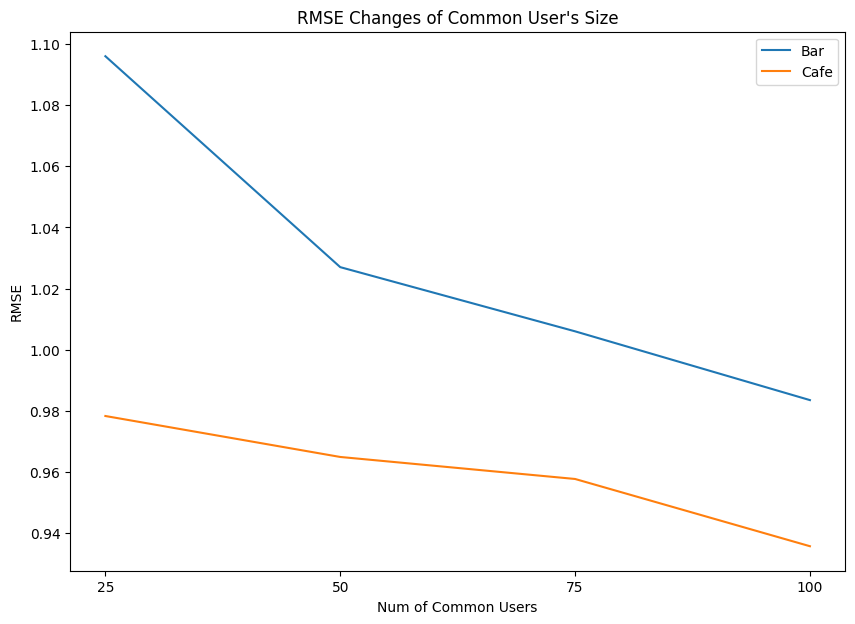

In [ ]:
bar_rmse = [1.096, 1.027, 1.006, 0.9835]
bar_mae = [0.8856, 0.8225, 0.8090, 0.7860]
cafe_rmse = [0.9783, 0.9649, 0.9577, 0.9357]
cafe_mae = [0.7786, 0.7653, 0.7569, 0.7396]

plt.figure(figsize=(10, 7))
plt.title("RMSE Changes of Common User's Size")
plt.plot([25, 50, 75, 100], bar_rmse)
plt.plot([25, 50, 75, 100], cafe_rmse)
plt.xlabel('Num of Common Users')
plt.ylabel('RMSE')
plt.xticks(np.arange(25, 125, 25))
plt.legend(['Bar', 'Cafe'])
plt.show()

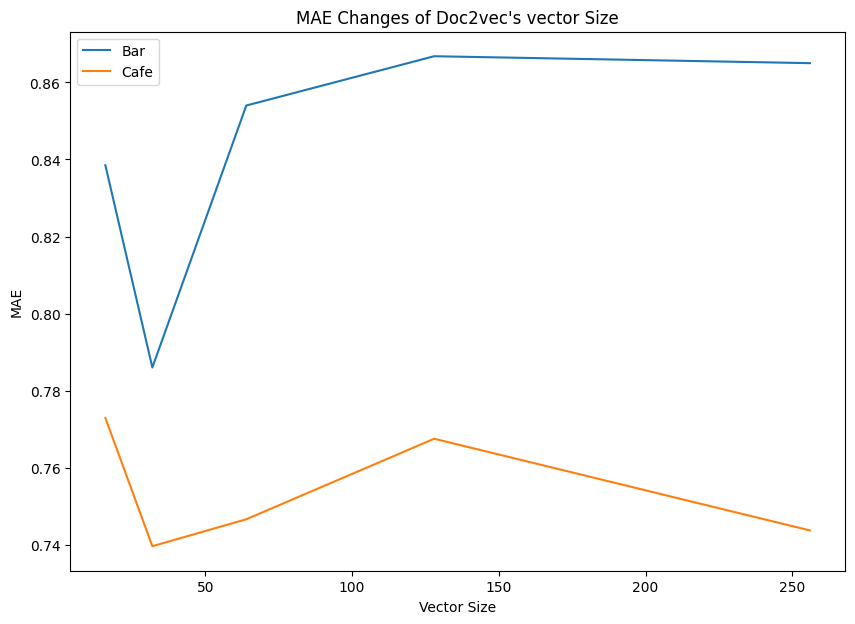

In [ ]:
plt.figure(figsize=(10, 7))
plt.title("MAE Changes of Doc2vec's vector Size")
plt.plot([16, 32, 64, 128, 256], bar_mae)
plt.plot([16, 32, 64, 128, 256], cafe_mae)
plt.xlabel('Vector Size')
plt.ylabel('MAE')
plt.legend(['Bar', 'Cafe'])
plt.show()